In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim import corpora, models, similarities, matutils
from gensim.models import CoherenceModel


import nltk
from nltk.corpus import stopwords

from pprint import pprint

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer


In [2]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/cleanedData.csv')

## Get a balanced sample of 5 songs per genre

In [3]:
num_genres = 2
num_topics = 6
genres = ['Country', 'Hip-Hop']
topic_columns = [i for i in range(0, num_topics)]
label_lookup = {
    0: "Country",
    1: "Hip-Hop"
}

In [4]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data[song_data["Genre"].isin(genres)]
song_data = song_data.groupby('Genre').sample(1500, random_state=42).reset_index(drop=True)
song_data.head(10)

,Genre,Lyrics
0,Country,IF YOU'RE GOIN' GIRL WRITER BOBBY BOND If you'...
1,Country,I'd rather live a life of lies and fantasy Tha...
2,Country,Well I'm making out my list For ole St.Nick to...
3,Country,Though you've gone away I play your favorite s...
4,Country,"DADDY'S LITTLE GIRL Writers Bobby Burke, Horac..."
5,Country,SANTA HO HO HO HO HO hohohohohohoho And what d...
6,Country,In a tiny town where the biggest things Were t...
7,Country,"(I sit here and look at you, lonely room it's ..."
8,Country,I've got this sensitive condition It's aggriva...
9,Country,"I'm traveling down this lonesome road, oh, how..."


## Remove punctuation/lower casing

In [5]:
song_data_processed = song_data.copy()
# removing everything except alphabets`
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].str.replace("[^a-zA-Z#]", " ")
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].str.replace("\'", " ")
# removing short words (shorter than 3 characters)
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].apply(lambda x: x.lower())
song_data_processed

,Genre,Lyrics
0,Country,goin girl writer bobby bond goin girl summerti...
1,Country,rather live life lies fantasy than face truth ...
2,Country,well making list st.nick tonight afraid what w...
3,Country,though gone away play your favorite song blue ...
4,Country,"daddy little girl writers bobby burke, horace ..."
...,...,...
2995,Hip-Hop,scott larock main topic looking cuts cash flow...
2996,Hip-Hop,alone night body craves music play make love m...
2997,Hip-Hop,[chorus] deep your love girl serious deep your...
2998,Hip-Hop,"like smokin loud, like being might drop them b..."


## Remove stopwords and Tokenize

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stop_words = stopwords.words('english')
new_stop_words = ['ooh','oh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa', 'intro', 'chorus', 'bridge', 'refrain']
stop_words.extend(new_stop_words)

max_df: je niedriger dieser Wert, desto mehr Mainstream wörter, die in allen songs vorkommen, werden nicht beachtet

In [8]:
#Turn Lyrics into vectorized form (based on counts)
count_vec = CountVectorizer(stop_words=stop_words, max_df=0.2, min_df=0.01, ngram_range=(1,1))
words_df = count_vec.fit_transform(song_data_processed.Lyrics)

In [9]:
words_df = words_df.transpose()
corpus = matutils.Sparse2Corpus(words_df)
id2word = dict((v, k) for k, v in count_vec.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=100, random_state=11)

In [10]:
for topic_num, terms in lda.show_topics(formatted=False):
    print(f"Topic {topic_num}:", end=" ")
    for term, prob in terms:
        print(term, end=" ")
    print("")

Topic 0: girl wanna would ever mind things gotta something really even 
Topic 1: girl wanna body girls turn lookin stop blow rock bout 
Topic 2: world white bump dance walk better step people shut man 
Topic 3: niggas niggaz real game fuckin gotta black bang play bitch 
Topic 4: money bitch niggas bitches verse fucking pussy hook hoes talk 
Topic 5: home away gone long always eyes world wish lord ever 


In [11]:
#umbrella term map for plotting
umbrella_topic_lookup = {
    0: "0-Heimatgefühle",
    1: "1-Persönliche Überzeugungen",
}

### Finding umbrella Terms for the Topics
•	Topic 0 – Heimatgefühle  
•	Topic 1 – Persönliche Überzeugungen  

### Auswertung Topics

In [11]:
docTopicProbMat = lda[corpus]
csr = matutils.corpus2csc(docTopicProbMat)
doc_top = csr.T.toarray()
doc_top_df = pd.DataFrame(doc_top, columns = [i for i in range(0, num_topics)])
results = pd.merge(song_data_processed, doc_top_df, left_index=True, right_index=True)
#Evaluate most dominant Topics
results['Dominant_Topic'] = results[[i for i in range(0, num_topics)]].idxmax(axis=1)
#Count number of appearing topics for each song
results['NonZeroTopics'] = (results.iloc[:, 2:12] != 0).sum(axis=1)
results.head(6)

,Genre,Lyrics,0,1,2,3,4,5,Dominant_Topic,NonZeroTopics
0,Country,goin girl writer bobby bond goin girl summerti...,0.167109,0.413545,0.151113,0.0,0.000000,0.257407,1,5
1,Country,rather live life lies fantasy than face truth ...,0.411436,0.000000,0.000000,0.0,0.000000,0.569366,5,3
2,Country,well making list st.nick tonight afraid what w...,0.585400,0.000000,0.000000,0.0,0.000000,0.383966,0,2
3,Country,though gone away play your favorite song blue ...,0.000000,0.000000,0.000000,0.0,0.000000,0.980934,5,2
4,Country,"daddy little girl writers bobby burke, horace ...",0.000000,0.448410,0.000000,0.0,0.000000,0.527637,5,3
5,Country,santa hohohohohohoho what want christmas littl...,0.000000,0.000000,0.048363,0.0,0.390184,0.549943,5,4


### Explore Results

#### Crosstab

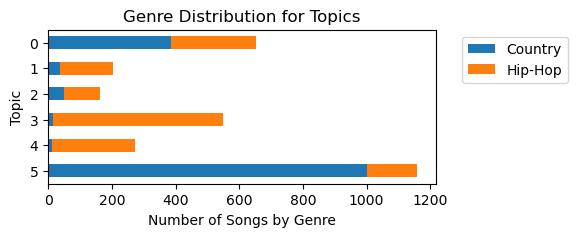

In [35]:
# Create a crosstab
crosstab = pd.crosstab(results['Dominant_Topic'], results['Genre']).sort_values(by="Dominant_Topic", ascending=False)

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True, figsize=(5,2)).legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Number of Songs by Genre')
plt.ylabel('Topic')
plt.title('Genre Distribution for Topics')
plt.show()

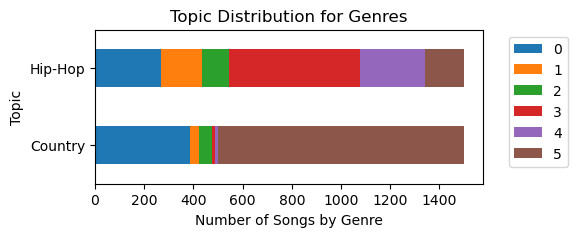

In [36]:
# Create a crosstab
crosstab = pd.crosstab(results['Genre'], results['Dominant_Topic'])

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True, figsize=(5,2)).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Topic')
plt.title('Topic Distribution for Genres')
plt.show()

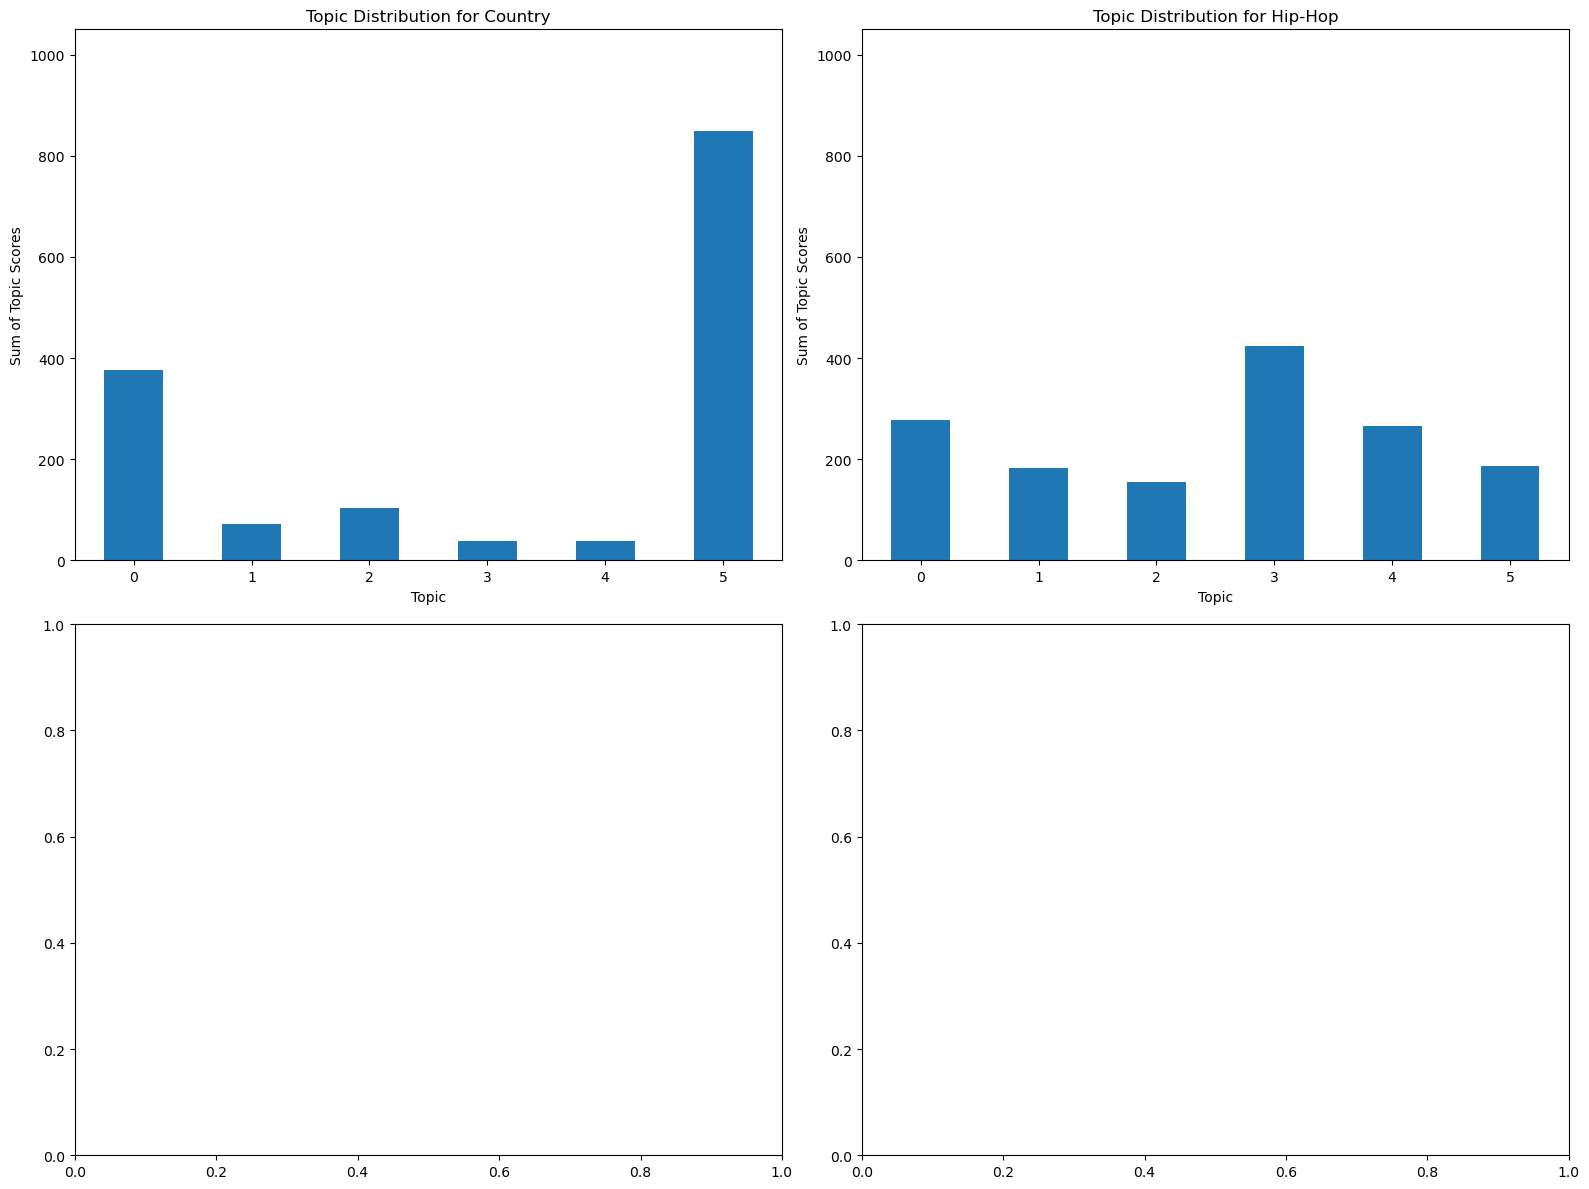

In [42]:
#Evaluate how many topics genres typically appear in (by summing up all the topic values instead of only looking at the most dominant one)
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # 3 rows, 4 columns

for i, genre in enumerate(genres):
    row = i // 4  # Row index
    col = i % 4   # Column index
    
    # Plotting
    results[results['Genre'] == genre][topic_columns].sum(axis=0).plot(kind='bar', ax=axs[row, col])
    axs[row, col].set_title(f'Topic Distribution for {genre}')
    axs[row, col].set_xlabel('Topic')
    axs[row, col].set_ylabel('Sum of Topic Scores')
    axs[row, col].tick_params(axis='x', rotation=0)  # Rotate x-labels for better readability
    axs[row][col].set_ylim(0, 1050)  # Set y-axis limit
    

plt.tight_layout()
plt.show()

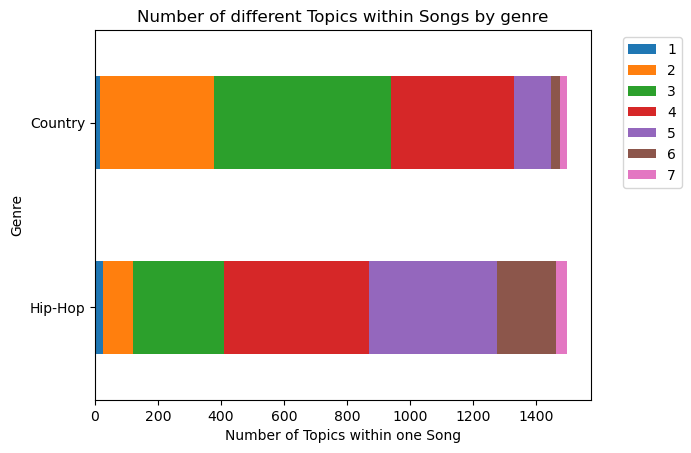

In [15]:
# Create a crosstab
crosstab = pd.crosstab(results['Genre'], results['NonZeroTopics']).sort_values(by="Genre", ascending=False)

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Topics within one Song')
plt.ylabel('Genre')
plt.title('Number of different Topics within Songs by genre')
plt.show()

#### Visualization (PCA) (visualizing LDA Results)

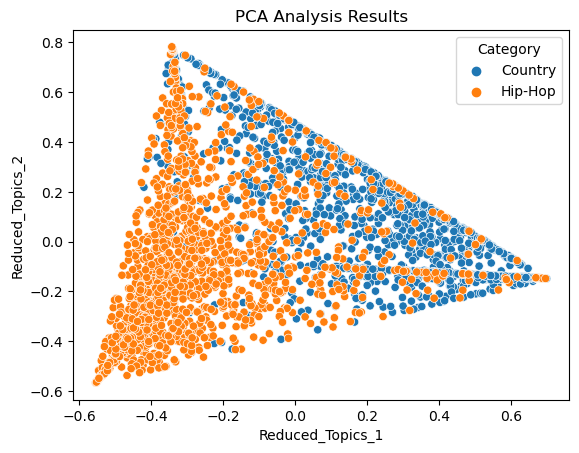

In [16]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(results[[i for i in range(0, num_topics)]])
results[['Reduced_Topics_1', 'Reduced_Topics_2']] = reduced
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

In [17]:
# # Create the subplot figure
# fig, axs = plt.subplots(3, 4, figsize=(12, 8))  # Adjust figsize as needed

# # Iterate over genres and create scatter plots in each subplot
# for i, genre in enumerate(genres):
#     row = i // 4
#     col = i % 4
#     sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results[results['Genre'] == genre], ax=axs[row][col])
#     axs[row][col].set_title(f'{genre} - PCA')
#     axs[row][col].legend(title='Category')
#     axs[row][col].set_xlim(-0.7, 0.7)  # Set x-axis limit
#     axs[row][col].set_ylim(-0.5, 0.75)  # Set y-axis limit

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()

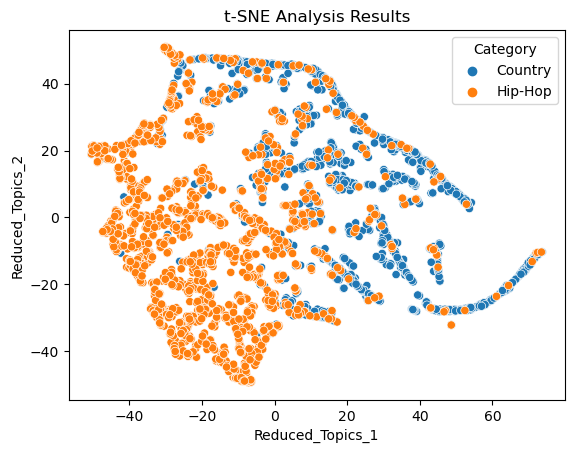

In [18]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the data to 2 dimensions
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
reduced = tsne.fit_transform(results[[i for i in range(0, num_topics)]])
results[['Reduced_Topics_1', 'Reduced_Topics_2']] = reduced

#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results)
plt.title('t-SNE Analysis Results')
plt.legend(title='Category')
plt.show()

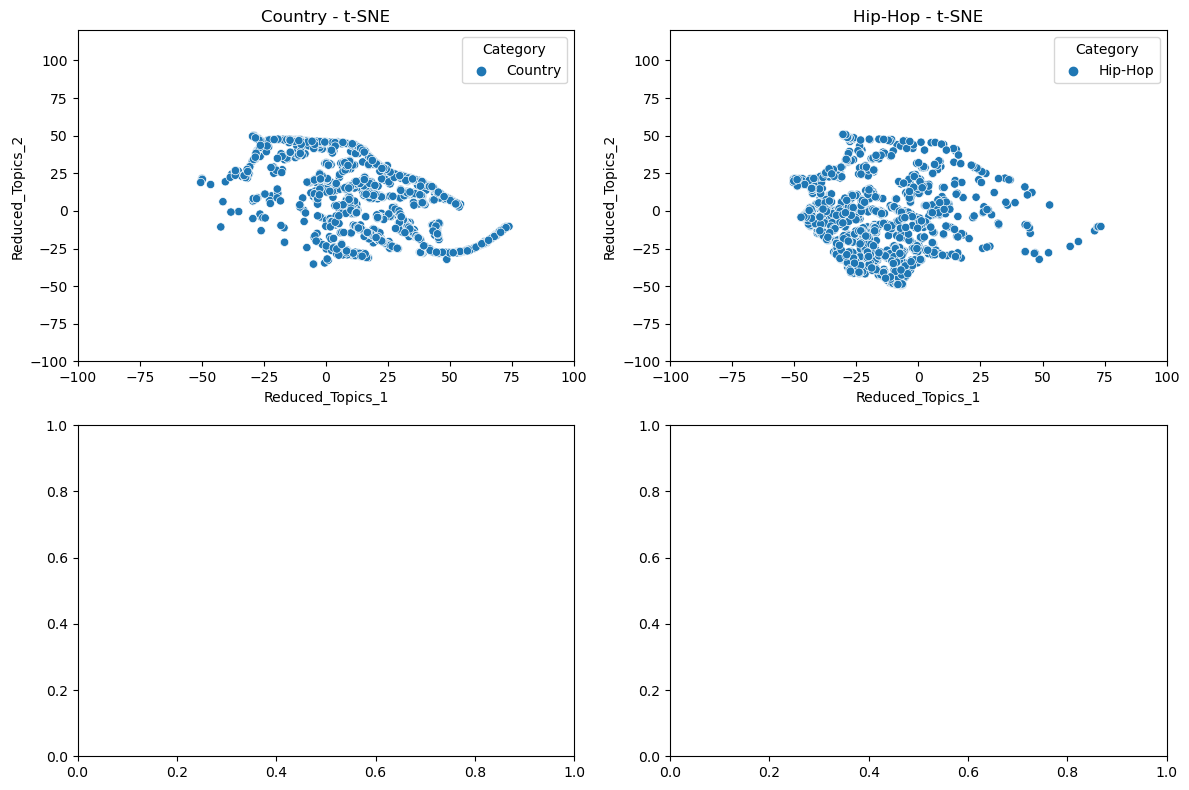

In [43]:
# Create the subplot figure
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # Adjust figsize as needed

# Iterate over genres and create scatter plots in each subplot
for i, genre in enumerate(genres):
    row = i // 4
    col = i % 4
    sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results[results['Genre'] == genre], ax=axs[row][col])
    axs[row][col].set_title(f'{genre} - t-SNE')
    axs[row][col].legend(title='Category')
    axs[row][col].set_xlim(-100, 100)  # Set x-axis limit
    axs[row][col].set_ylim(-100, 120)  # Set y-axis limit

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Using Clustering

In [20]:
kmeans = KMeans(n_clusters=num_genres, random_state=0).fit(results[[i for i in range(0, num_topics)]])
results["Cluster"] = kmeans.labels_
results

c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Genre,Lyrics,0,1,2,3,4,5,Dominant_Topic,NonZeroTopics,Reduced_Topics_1,Reduced_Topics_2,Cluster
0,Country,goin girl writer bobby bond goin girl summerti...,0.167109,0.413545,0.151113,0.000000,0.000000,0.257407,1,5,-10.529439,3.842589,0
1,Country,rather live life lies fantasy than face truth ...,0.411436,0.000000,0.000000,0.000000,0.000000,0.569366,5,3,20.985668,31.047350,1
2,Country,well making list st.nick tonight afraid what w...,0.585400,0.000000,0.000000,0.000000,0.000000,0.383966,0,2,5.174515,44.815224,0
3,Country,though gone away play your favorite song blue ...,0.000000,0.000000,0.000000,0.000000,0.000000,0.980934,5,2,66.649155,-18.269659,1
4,Country,"daddy little girl writers bobby burke, horace ...",0.000000,0.448410,0.000000,0.000000,0.000000,0.527637,5,3,29.173758,-1.028265,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Hip-Hop,scott larock main topic looking cuts cash flow...,0.254063,0.365839,0.180229,0.197013,0.000000,0.000000,1,5,-12.477468,-10.890090,0
2996,Hip-Hop,alone night body craves music play make love m...,0.677609,0.000000,0.000000,0.000000,0.000000,0.309179,0,2,-3.454674,46.158508,0
2997,Hip-Hop,[chorus] deep your love girl serious deep your...,0.754353,0.231903,0.000000,0.000000,0.000000,0.000000,0,2,-29.092958,34.256725,0
2998,Hip-Hop,"like smokin loud, like being might drop them b...",0.210032,0.157553,0.000000,0.000000,0.628049,0.000000,4,4,-38.436901,1.195097,0


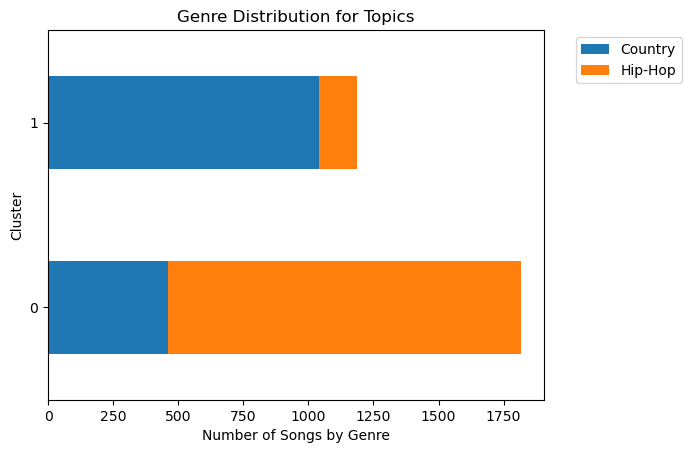

In [21]:
# Create a crosstab
crosstab = pd.crosstab(results['Cluster'], results['Genre'])

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Cluster')
plt.title('Genre Distribution for Topics')
plt.show()

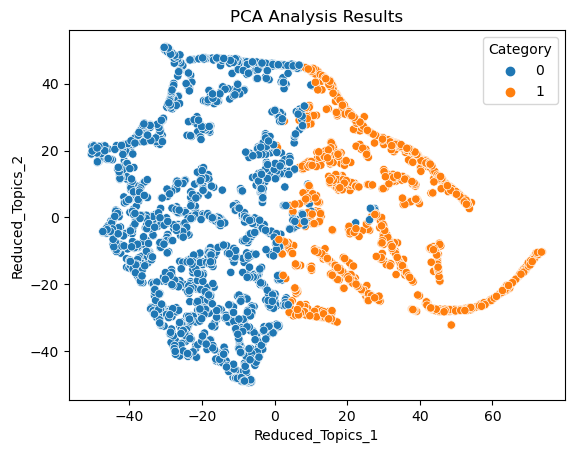

In [22]:
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Cluster', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Trying to predict the genre based on the topic vector

In [23]:
X = results[[i for i in range(0, num_topics)]]
label_encoder = LabelEncoder()
results["GenreID"] = label_encoder.fit_transform(results["Genre"])
y = results["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [24]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.8555555555555555

In [25]:
#svm classifier
svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.8611111111111112

In [26]:
#Random forest
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8377777777777777

### Get Classification Matrix (of knn)

In [27]:
y_pred = svc.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       461
           1       0.90      0.81      0.85       439

    accuracy                           0.86       900
   macro avg       0.87      0.86      0.86       900
weighted avg       0.86      0.86      0.86       900



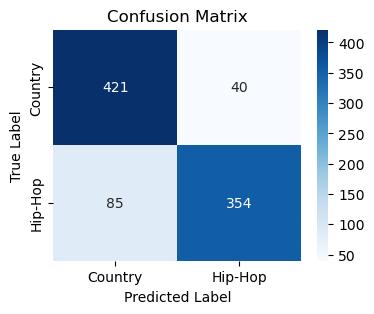

In [46]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the class labels
class_labels = np.array([label_lookup.get(i) for i in svc.classes_])

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [29]:
results[["Genre", "GenreID"]].drop_duplicates()

,Genre,GenreID
0,Country,0
1500,Hip-Hop,1


### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus den Genres HipHop und Country
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Using LDA to get most important topic based on all the songs
- applying the LDA topics to each song individually
- Investigating whether there is a correlation between the topics and the song genres, using crosstabs and, PCA-Scatterplots and Clustering
- Investigating whether it is possible to predict a genre based on its most prominent topics 
- Variation der Anzahl der topics um zu vergleichen was die besten ergebnisse liefert

### Ergebnis
- Starker unterschied zwischen den Themen bei HipHop und Country Songs
- Country Songs fallen kaum in die Hip-Hop Kategorie, während dies anders herum schon teilweise der Fall ist (HipHop ist also doch etwas offener im Topic)
- Starkes HipHop Topic mit vielen slang begriffen, während country category etwas freier gehalten ist (zumindest bei 2 topics)
- Ergebnisse sehr viel eindeutiger als bei der Vorherigen Lösung
- Vorhersage des Genres aus Topics extrem gut möglich, accuracy bis zu 87%
- Die Ergebnisse sind nahezu identisch bei Erhöhung der Anzahl der Topics auf 10, einzig die PCA zeigt dabei etwas visuellere Ergebnisse und auch das Clustering scheint in Ordnung zu funktionieren
- Bei 20 Topics nimmt die Qualität der Ergebnisse ab
- ca. 5 topics scheint der sweet spot zu sein, damit steigt die accuracy auf bis zu 89%
- Clustering der Ergebnisse Funktioniert nicht, dafür sind die Ergebnisse nicht eindeutig genug abgetrennt


### Interpretation
- Das Model funktioniert bereits besser als das vorherige. Die Vermutung liegt nahe, dass es zwischen manchen Genres mehr Unterschiede als zwischen anderen gibt. Ein gutes beispiel dafür ist HipHop, das sich relativ klar unterscheiden lässt.
- Es ist gut möglich anhand der Lyrics zu unterscheiden ob ein Song Hip-Hop oder Country zugeordnet werden kann